In [1]:
import numpy as np
from functions.propagators import CR3BP
import scipy as sp
from functions.read_ICs import read_ICs
from functions.dwell_times import hist_linear_density, altitude_blocks
# from scipy import integrate

ids = [25, 100, 150, 200, 400, 600]
tf, DRO_ICs = read_ICs("data/ICs_DRO.csv", ids)
base_propagator = CR3BP(LU=389703, TU=382981)

inertial_states = []
CR3BP_states = []
times = []
for idx in range(len(ids)):
    base_propagator.propagate(DRO_ICs[idx, :], tf[idx])
    base_propagator.get_inertial_states()
    inertial_states.append(base_propagator.states)
    CR3BP_states.append(base_propagator.states_cr3bp)
    times.append(base_propagator.ts)

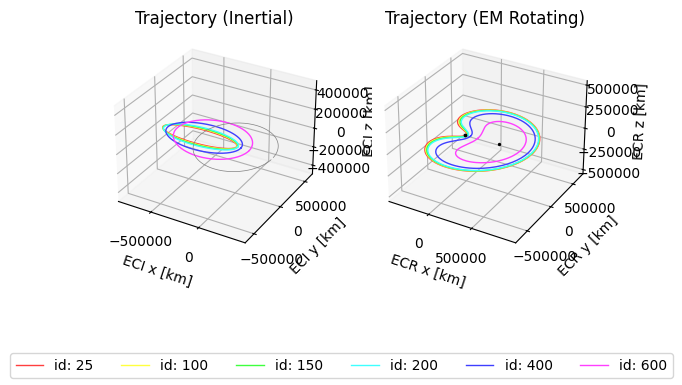

In [2]:
from functions.plot_trajectories import plot_trajectories

plot_trajectories(
    inertial_states,
    CR3BP_states,
    base_propagator.moonstate,
    [
        (1 - base_propagator.mu) * base_propagator.LU,
        (-base_propagator.mu) * base_propagator.LU,
    ],
    ids,
)

# General idea:
### Integrate probability of cohabitation at the same altitude
$$p_i=\int_R p_\rho(r)p_t(r)\mathrm{d}r$$
$$\begin{aligned}
p_i &: \text{Probability of interaction}\\
p_\rho &: \text{Probability based on radius density of some reference region}\\
p_t &: \text{Probability based on radius density of trajectory}\\
\end{aligned}$$

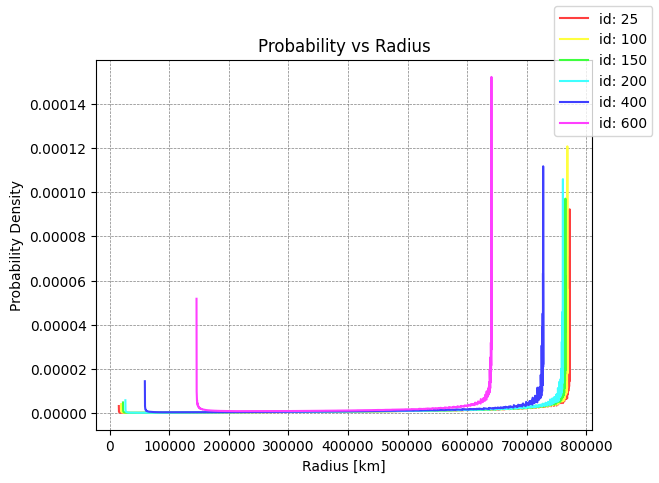

In [3]:
ps, alts = hist_linear_density(
    CR3BP_states,
    times,
    tf * base_propagator.TU,
    (-base_propagator.mu) * base_propagator.LU,
    ids,
    # alt_range=(0,2*base_propagator.LU),
)

# Case 1: MEO Linear

$$p_\rho = \begin{cases}
\frac{1}{r_\text{max}-r_\text{min}}&r_\text{max}\leq r \leq r_\text{min}\\
0 & \text{Otherwise}\\
\end{cases}$$

In [4]:
alt_block = (20000 + 6371, 30000 + 6371)

pMEO_hist = []
for i in range(len(ids)):
    indices = (alts[i] >= alt_block[0]) * (alts[i] < alt_block[1])
    pMEO_hist.append(
        np.trapezoid(ps[i][indices], alts[i][indices])
    )
pMEO_altBlocks = altitude_blocks(
    CR3BP_states,
    times,
    tf * base_propagator.TU,
    (-base_propagator.mu) * base_propagator.LU,
    ids,
    {"LEO": alt_block},
)


In [5]:
pMEO_hist

[np.float64(0.0023574),
 np.float64(0.00272605),
 np.float64(0.0031999499999999996),
 np.float64(0.005198099999999997),
 np.float64(0.0),
 np.float64(0.0)]

In [6]:
pMEO_altBlocks

[{'LEO': np.float64(0.0023771443917257936)},
 {'LEO': np.float64(0.002733815247099385)},
 {'LEO': np.float64(0.0032405365425554142)},
 {'LEO': np.float64(0.005398518513313234)},
 {'LEO': np.float64(0.0)},
 {'LEO': np.float64(0.0)}]

# Case 2: MEO weighted by proximity to 12hr orbit
### Standard deviation of 3000 km (so Galileo is roughly 1sigma)

$$p_\rho \sim \mathcal{N}(r_\text{MEO},\ 3000^2\ \mathrm{km^2})$$

In [7]:
GPSalt = 26560
cluster_pdf = sp.stats.norm(loc=26560, scale=3000)
normal_pts = [cluster_pdf.pdf(alts_run) for alts_run in alts]
totProb = [normal_pts[i] * ps[i] for i in range(len(ids))]
pMEO_prod = []
for i in range(len(ids)):
    pMEO_prod.append(
        np.trapezoid(totProb[i], alts[i])
    )

In [8]:
pMEO_prod

[np.float64(2.4221800019941263e-07),
 np.float64(3.0793943336811305e-07),
 np.float64(4.117057114703169e-07),
 np.float64(4.064077947230074e-07),
 np.float64(6.734995874188119e-33),
 np.float64(0.0)]

# Ingest TLE data

$$p_\rho = f(n_\text{TLE})$$

In [9]:
from functions.tle_histogram import SMA_GMM
import sklearn.mixture

In [10]:
def eval_GMM_PDF(model: sklearn.mixture.GaussianMixture, x):
    means = model.means_.flatten()
    wts = model.weights_.flatten()
    covars = model.covariances_
    prob_densities = np.zeros_like(x)
    for n in range(len(means)):
        cluster_pdf = sp.stats.norm(loc=means[n], scale=np.sqrt(covars[n]))
        prob_densities += wts[n] * cluster_pdf.pdf(x).squeeze()
    return prob_densities

### GMM with 1 cluster

In [11]:
gmm_1 = SMA_GMM("data/tles.txt", 1)
gmm1_pdf = [eval_GMM_PDF(gmm_1, alts_run) for alts_run in alts]
gmm1_prob = [gmm1_pdf[i] * ps[i] for i in range(len(ids))]
pGMM1_prod = []
for i in range(len(ids)):
    pGMM1_prod.append(np.trapezoid(gmm1_prob[i], alts[i]))
pGMM1_prod

[np.float64(1.1381350193466422e-07),
 np.float64(9.393112067602939e-08),
 np.float64(7.199170195815651e-08),
 np.float64(4.4978649464492784e-08),
 np.float64(4.098785523476324e-12),
 np.float64(1.0915746512520161e-43)]

### GMM with 2 clusters

In [12]:
gmm_2 = SMA_GMM("data/tles.txt", 2)
gmm2_pdf = [eval_GMM_PDF(gmm_2, alts_run) for alts_run in alts]
gmm2_prob = [gmm2_pdf[i] * ps[i] for i in range(len(ids))]
pGMM2_prod = []
for i in range(len(ids)):
    pGMM2_prod.append(np.trapezoid(gmm2_prob[i], alts[i]))
pGMM2_prod

[np.float64(3.708170606762862e-08),
 np.float64(3.978232632686898e-08),
 np.float64(4.1494161549648324e-08),
 np.float64(4.2259349773663526e-08),
 np.float64(5.488912040370089e-09),
 np.float64(1.8344821147159625e-21)]

### GMM with 3 clusters

In [13]:
gmm_3 = SMA_GMM("data/tles.txt", 3)
gmm3_pdf = [eval_GMM_PDF(gmm_3, alts_run) for alts_run in alts]
gmm3_prob = [gmm3_pdf[i] * ps[i] for i in range(len(ids))]
pGMM3_prod = []
for i in range(len(ids)):
    pGMM3_prod.append(np.trapezoid(gmm3_prob[i], alts[i]))
pGMM3_prod

[np.float64(3.7312081223831004e-08),
 np.float64(4.146920841538429e-08),
 np.float64(4.773213571788518e-08),
 np.float64(4.76640481131138e-08),
 np.float64(7.213242556029409e-09),
 np.float64(7.506273919537217e-19)]

### GMM with 4 clusters

In [14]:
gmm_4 = SMA_GMM("data/tles.txt", 4)
gmm4_pdf = [eval_GMM_PDF(gmm_4, alts_run) for alts_run in alts]
gmm4_prob = [gmm4_pdf[i] * ps[i] for i in range(len(ids))]
pGMM4_prod = []
for i in range(len(ids)):
    pGMM4_prod.append(np.trapezoid(gmm4_prob[i], alts[i]))
pGMM4_prod

[np.float64(3.911316502841902e-08),
 np.float64(4.162193843263653e-08),
 np.float64(4.1769259761467474e-08),
 np.float64(3.909752201816724e-08),
 np.float64(7.78608284655213e-10),
 np.float64(5.85628791292158e-10)]

### GMM with 5 clusters

In [15]:
gmm_5 = SMA_GMM("data/tles.txt", 5)
gmm5_pdf = [eval_GMM_PDF(gmm_5, alts_run) for alts_run in alts]
gmm5_prob = [gmm5_pdf[i] * ps[i] for i in range(len(ids))]
pGMM5_prod = []
for i in range(len(ids)):
    pGMM5_prod.append(np.trapezoid(gmm5_prob[i], alts[i]))
pGMM5_prod

[np.float64(3.919199627052457e-08),
 np.float64(4.169478140704036e-08),
 np.float64(4.1759645449957124e-08),
 np.float64(3.892315882976959e-08),
 np.float64(1.0009921708470177e-09),
 np.float64(2.245036032508779e-10)]